In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#Set Parameters
im_width = 256
im_height = 256

In [ ]:
train_files = []

mask_files = glob(r"/content/drive/MyDrive/project/mammogram/*/*_mask*")

for i in mask_files:
    train_files.append(i.replace('_mask',''))

train_files[1:300]
#mask_files[1:300]

['/content/drive/MyDrive/project/mammogram/malignant/malignant_7.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_6.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_17.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_66.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_20.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_18.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_15.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_9.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_23.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_61.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_60.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_62.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_5.png',
 '/content/drive/MyDrive/project/mammogram/malignant/malignant_1.png

In [ ]:
df = pd.DataFrame(data={ "filename" : train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(28, 2)
(8, 2)
(4, 2)


In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

def F1(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall
 
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       activation[0][0]                 
_______________________________________________________________________________________

In [ ]:
EPOCHS = 150
BATCH_SIZE = 4
learning_rate = 1e-4

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
model = unet(input_size=(im_height, im_width, 3))

decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss = dice_coef_loss, metrics = ["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_breast_mammogram_seg.hdf5', verbose=1, save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 28 validated image filenames.
Found 28 validated image filenames.
Epoch 1/150
7/7 [==============================] - ETA: 0s - loss: 0.2057 - binary_accuracy: 0.4579 - iou: 0.1915 - dice_coef: 0.7943Found 8 validated image filenames.
Found 8 validated image filenames.

Epoch 00001: val_loss improved from inf to 0.17255, saving model to unet_breast_mammogram_seg.hdf5
7/7 [==============================] - 23s 3s/step - loss: 0.2057 - binary_accuracy: 0.4579 - iou: 0.1915 - dice_coef: 0.7943 - val_loss: 0.1725 - val_binary_accuracy: 0.6912 - val_iou: 0.1959 - val_dice_coef: 0.8275
Epoch 2/150
7/7 [==============================] - ETA: 0s - loss: 0.1595 - binary_accuracy: 0.6656 - iou: 0.1909 - dice_coef: 0.8405
Epoch 00002: val_loss improved from 0.17255 to 0.16740, saving model to unet_breast_mammogram_seg.hdf5
7/7 [==============================] - 3s 377ms/step - loss: 0.1595 - binary_accuracy: 0.6656 - iou: 0.1909 - dice_coef: 0.8405 - val_loss: 0.1674 - val_binary_accuracy: 0

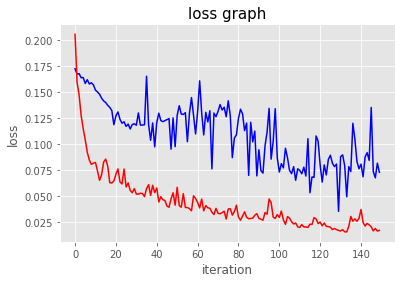

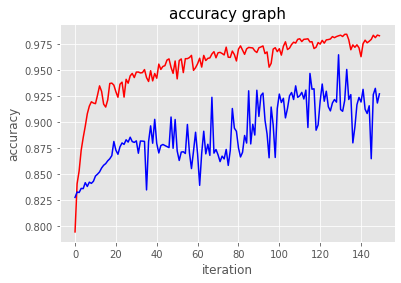

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [ ]:
model = load_model('unet_breast_mammogram_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 4 validated image filenames.
Found 4 validated image filenames.
1/1 [==============================] - 0s 2ms/step - loss: 0.0523 - binary_accuracy: 0.8842 - iou: 0.1345 - dice_coef: 0.9477
Test lost:  0.05229635909199715
Test IOU:  0.8841972351074219
Test Dice Coefficent:  0.13454826176166534


In [ ]:
for layer in model.layers[:-1]:
    layer.trainable = False
    print(layer.name)

inputs = model.output

input_2
conv2d_19
activation_18
conv2d_20
batch_normalization_9
activation_19
max_pooling2d_4
conv2d_21
activation_20
conv2d_22
batch_normalization_10
activation_21
max_pooling2d_5
conv2d_23
activation_22
conv2d_24
batch_normalization_11
activation_23
max_pooling2d_6
conv2d_25
activation_24
conv2d_26
batch_normalization_12
activation_25
max_pooling2d_7
conv2d_27
activation_26
conv2d_28
batch_normalization_13
activation_27
conv2d_transpose_4
concatenate_4
conv2d_29
activation_28
conv2d_30
batch_normalization_14
activation_29
conv2d_transpose_5
concatenate_5
conv2d_31
activation_30
conv2d_32
batch_normalization_15
activation_31
conv2d_transpose_6
concatenate_6
conv2d_33
activation_32
conv2d_34
batch_normalization_16
activation_33
conv2d_transpose_7
concatenate_7
conv2d_35
activation_34
conv2d_36
batch_normalization_17
activation_35


In [ ]:
train_Ultra_files = []

mask_Ultra_files = glob("/content/drive/MyDrive/project/Dataset_BUSI_with_GT/*/*_mask*")

for i in mask_Ultra_files:
    train_Ultra_files.append(i.replace('_mask',''))

#train_Ultra_files[1:300]

In [ ]:
df = pd.DataFrame(data={ "filename1" : train_Ultra_files, 'mask1' : mask_Ultra_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(246, 2)
(62, 2)
(35, 2)


In [ ]:
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename1",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask1",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)


In [ ]:
for layer in model.layers[:-1]:
  layer.trainable = False

inputs = model.output

conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
bn1 = Activation('relu')(conv1)
conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
bn1 = BatchNormalization(axis=3)(conv1)
bn1 = Activation('relu')(bn1)
pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
bn2 = Activation('relu')(conv2)
conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
bn2 = BatchNormalization(axis=3)(conv2)
bn2 = Activation('relu')(bn2)
pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
bn3 = Activation('relu')(conv3)
conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
bn3 = BatchNormalization(axis=3)(conv3)
bn3 = Activation('relu')(bn3)
pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
bn4 = Activation('relu')(conv4)
conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
bn4 = BatchNormalization(axis=3)(conv4)
bn4 = Activation('relu')(bn4)
pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
bn5 = Activation('relu')(conv5)
conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
bn5 = BatchNormalization(axis=3)(conv5)
bn5 = Activation('relu')(bn5)

up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
conv6 = Conv2D(512, (3, 3), padding='same')(up6)
bn6 = Activation('relu')(conv6)
conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
bn6 = BatchNormalization(axis=3)(conv6)
bn6 = Activation('relu')(bn6)

up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
conv7 = Conv2D(256, (3, 3), padding='same')(up7)
bn7 = Activation('relu')(conv7)
conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
bn7 = BatchNormalization(axis=3)(conv7)
bn7 = Activation('relu')(bn7)

up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
conv8 = Conv2D(128, (3, 3), padding='same')(up8)
bn8 = Activation('relu')(conv8)
conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
bn8 = BatchNormalization(axis=3)(conv8)
bn8 = Activation('relu')(bn8)

up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
conv9 = Conv2D(64, (3, 3), padding='same')(up9)
bn9 = Activation('relu')(conv9)
conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
bn9 = BatchNormalization(axis=3)(conv9)
bn9 = Activation('relu')(bn9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

Transfer_learning_model  = Model(inputs=[model.input], outputs=[conv10])

In [ ]:
Transfer_learning_model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 64) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 64) 36928       activation_18[0][0]              
_______________________________________________________________________________________

In [ ]:
EPOCHS = 150
BATCH_SIZE = 32
learning_rate = 1e-4

In [ ]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
Transfer_learning_model.compile(optimizer=opt, loss = dice_coef_loss, metrics = ["binary_accuracy", iou, dice_coef])


In [ ]:
history = Transfer_learning_model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)


Found 246 validated image filenames.
Found 246 validated image filenames.
Epoch 1/150
8/7 [===============================] - ETA: -7s - loss: 0.0805 - binary_accuracy: 0.8711 - iou: 0.1256 - dice_coef: 0.9195Found 62 validated image filenames.
Found 62 validated image filenames.
8/7 [===============================] - 235s 29s/step - loss: 0.0805 - binary_accuracy: 0.8711 - iou: 0.1256 - dice_coef: 0.9195 - val_loss: 0.1913 - val_binary_accuracy: 0.8386 - val_iou: 0.0719 - val_dice_coef: 0.8087
Epoch 2/150
8/7 [===============================] - 17s 2s/step - loss: 0.0497 - binary_accuracy: 0.9098 - iou: 0.1730 - dice_coef: 0.9503 - val_loss: 0.1868 - val_binary_accuracy: 0.8515 - val_iou: 0.0798 - val_dice_coef: 0.8132
Epoch 3/150
8/7 [===============================] - 17s 2s/step - loss: 0.0414 - binary_accuracy: 0.9219 - iou: 0.1662 - dice_coef: 0.9586 - val_loss: 0.1826 - val_binary_accuracy: 0.8916 - val_iou: 0.0718 - val_dice_coef: 0.8174
Epoch 4/150
8/7 [======================

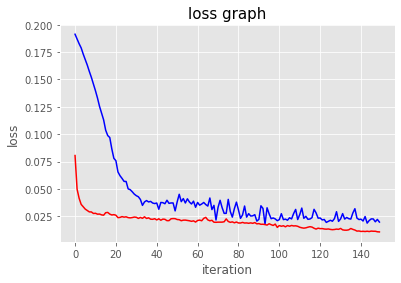

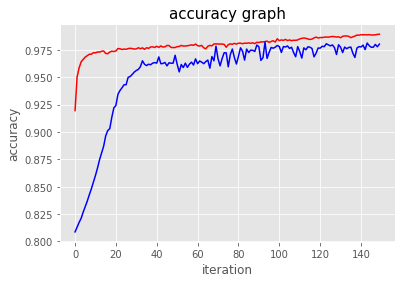

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def jac_distance(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)

    return - iou(y_true, y_pred)

In [ ]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = Transfer_learning_model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 35 validated image filenames.
Found 35 validated image filenames.
2/1 [======================================================] - 3s 1s/step - loss: 0.0181 - binary_accuracy: 0.9561 - iou: 0.2937 - dice_coef: 0.9819
Test lost:  0.018131360411643982
Test IOU:  0.9561030864715576
Test Dice Coefficent:  0.293739914894104


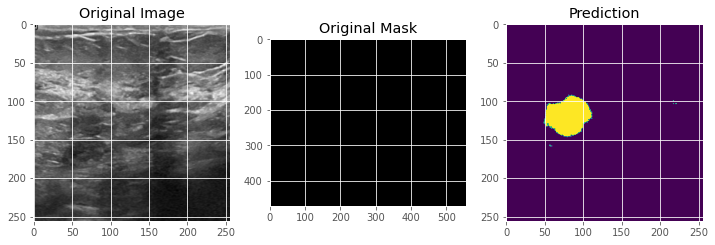

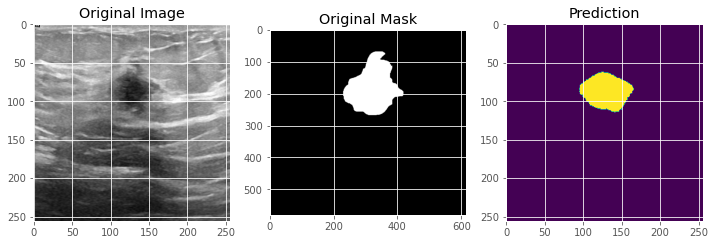

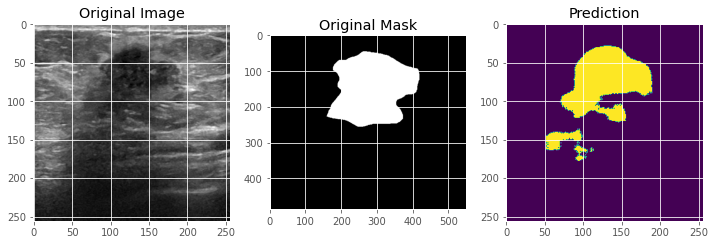

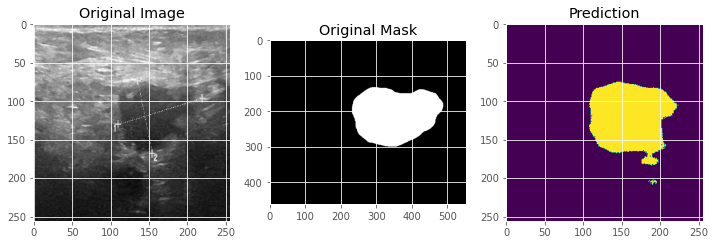

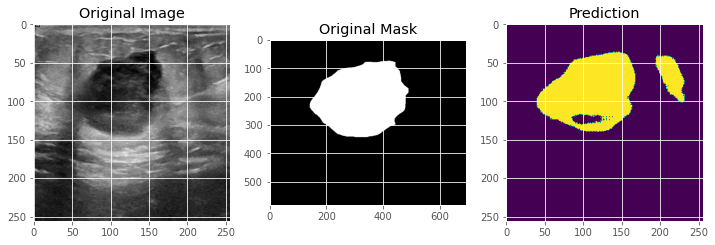

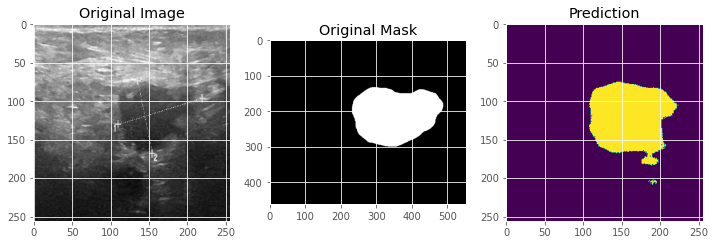

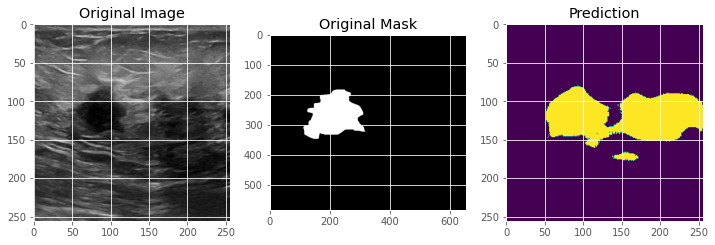

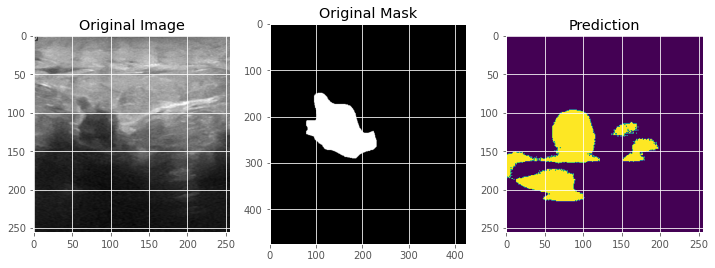

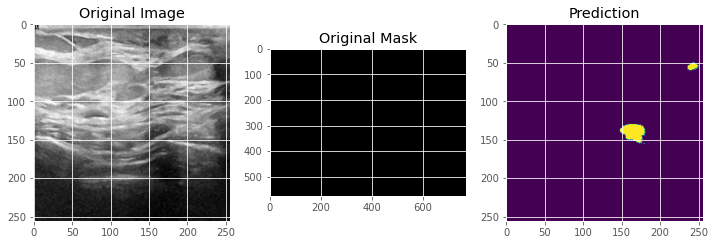

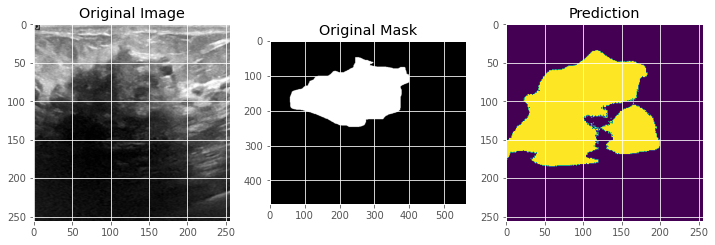

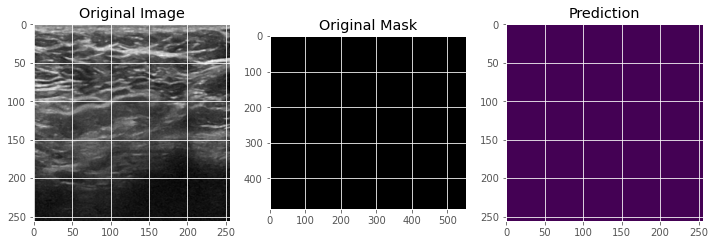

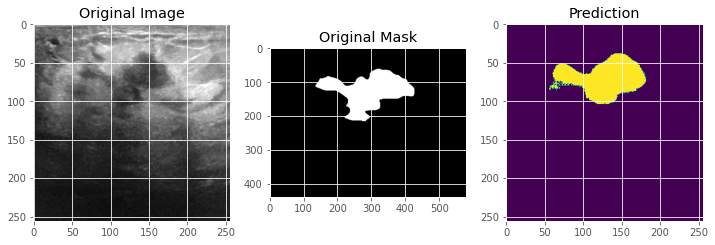

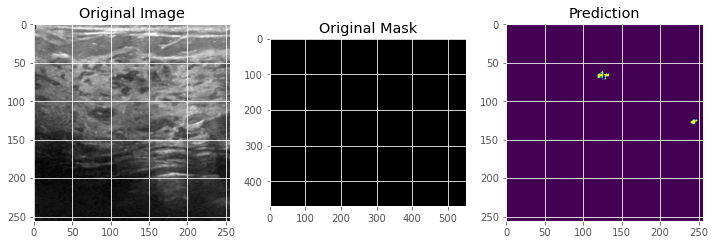

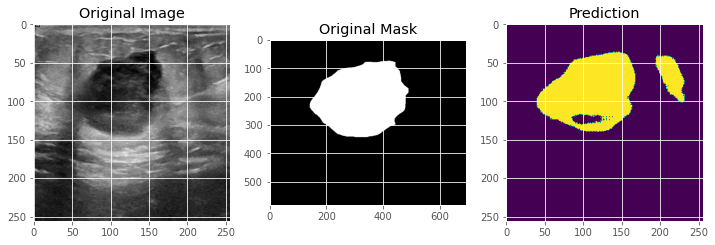

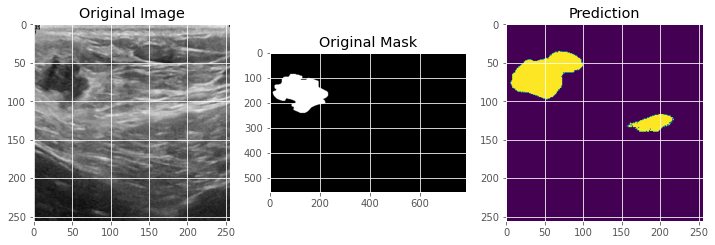

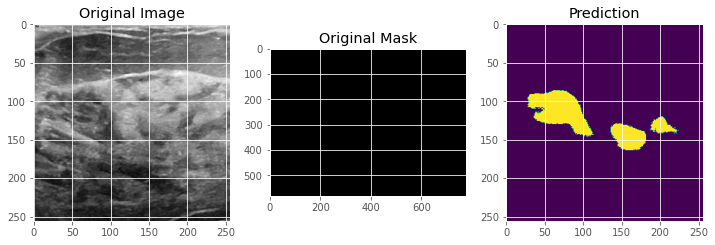

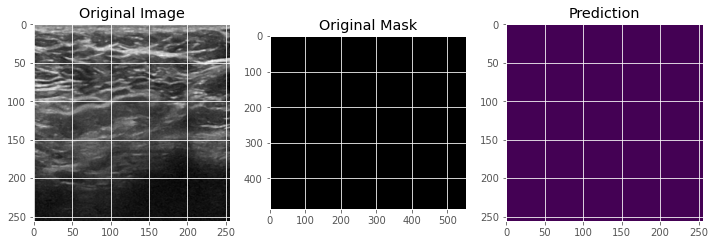

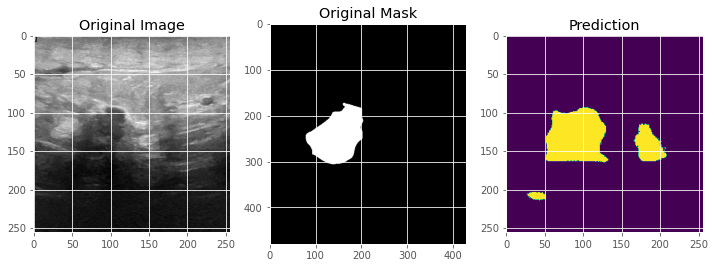

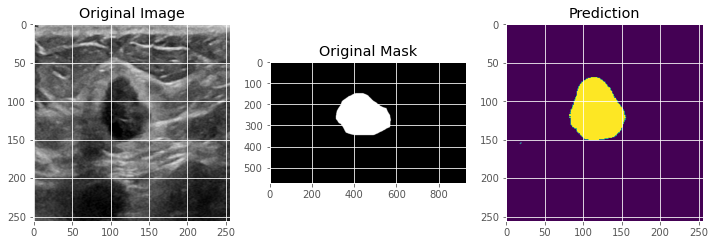

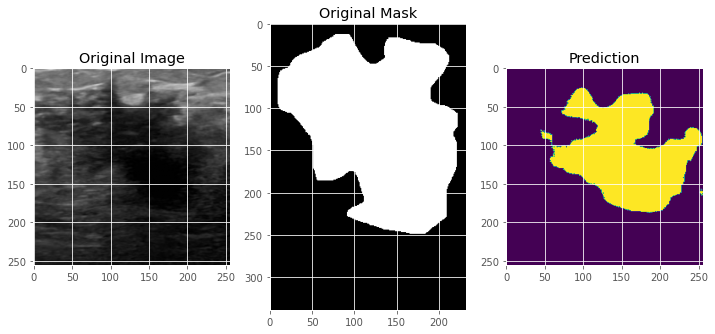

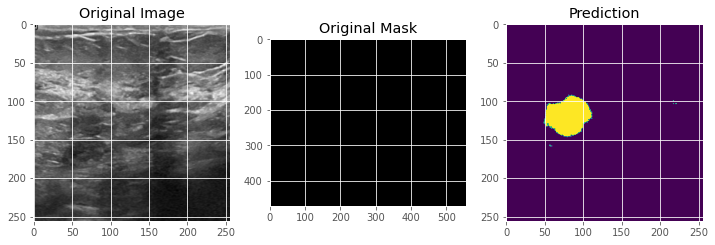

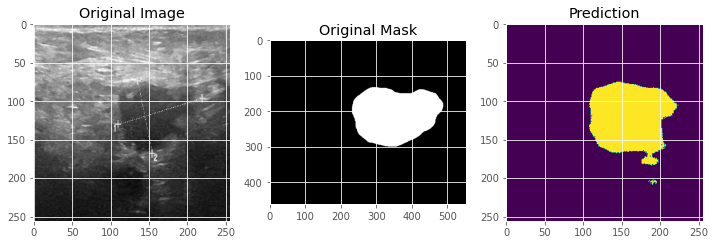

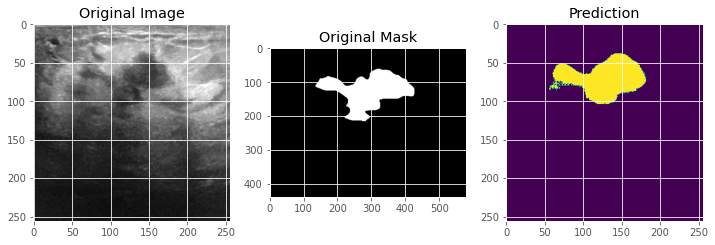

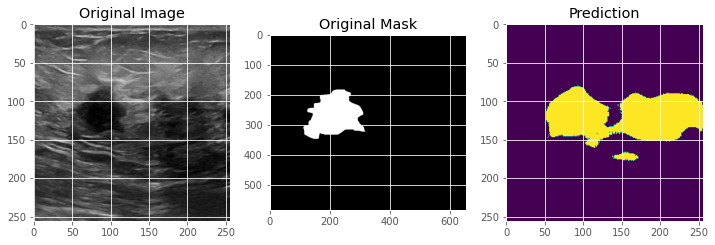

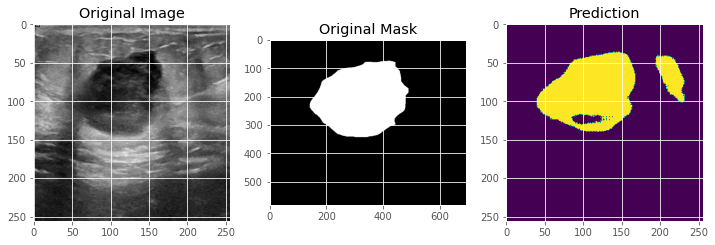

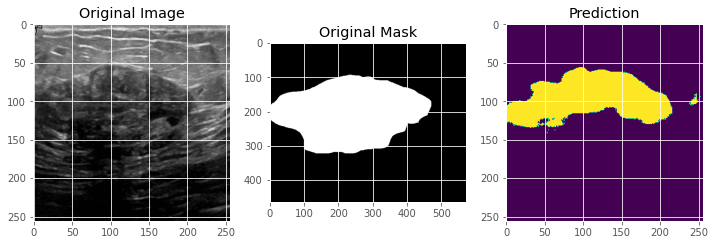

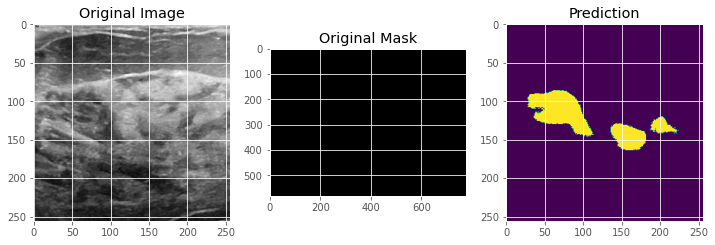

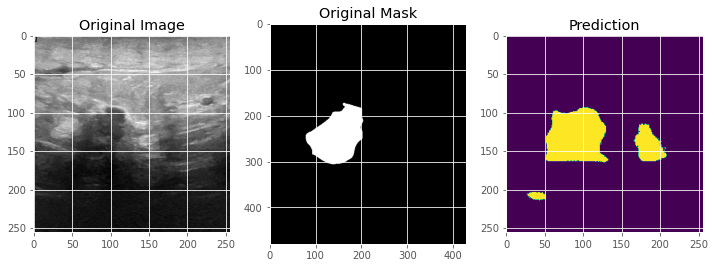

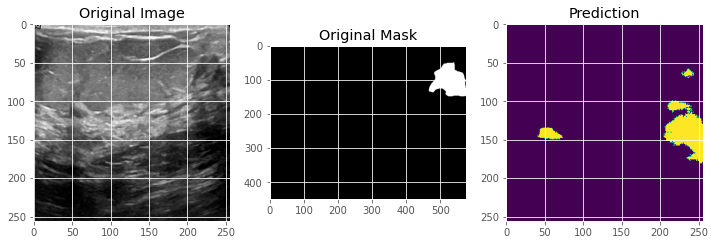

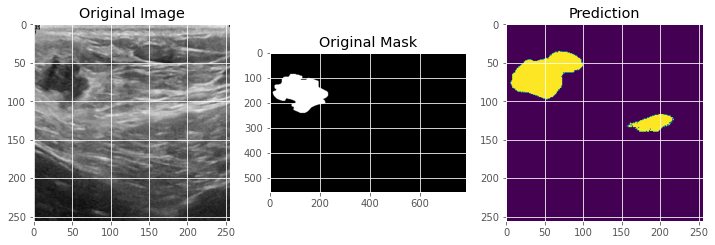

In [ ]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename1'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask1'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()